In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
from helpers import *
from helpers import *
from plots import *
from plots import *
from split_data import *
from recommender import *
from cross_validation import *
%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
path_dataset = "../data/data_train.csv"
ratings = load_data(path_dataset)

number of items: 10000, number of users: 1000


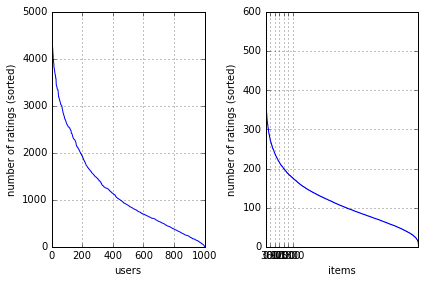

min # of items per user = 8, min # of users per item = 3.


In [3]:
num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

## Split data into training and test set

In [4]:
valid_ratings, train_validation, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
#plot_train_test_data(train_validation, test)

## Matrix factorisation using SGD

In [ ]:
%run run.py 0

## ALS

In [ ]:
%run run.py 1

## Other Methods
### CCD

In [15]:
%run run.py 2 --submit

Loading training data
number of items: 10000, number of users: 1000
Preprocessing data
Splitting data into train and test sets
Training model
learn the matrix factorization using CCD...
iter: 0, RMSE on training set: 1.0132227145887496.
iter: 1, RMSE on training set: 0.9916289373467113.
iter: 2, RMSE on training set: 0.9914653913430822.
iter: 3, RMSE on training set: 0.9914567918111359.
RMSE on test data: 1.0111300580433926.
RMSE on train data: 0.9914567918111359.
RMSE on test data: 1.0111300580433926.
Loading test data


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd3 in position 8: invalid continuation byte

## Cross validation

### Number of features

Running num_features=10
Running 1th fold in 10 folds
learn the matrix factorization using CCD...
iter: 0, RMSE on training set: 1.0118904881806587.
iter: 1, RMSE on training set: 0.9924894332829003.
iter: 2, RMSE on training set: 0.9923716848565357.
iter: 3, RMSE on training set: 0.9923669663246835.
RMSE on test data: 0.9923180087185254.
Running 2th fold in 10 folds
learn the matrix factorization using CCD...
iter: 0, RMSE on training set: 1.0118904881806587.
iter: 1, RMSE on training set: 0.9924894332829003.
iter: 2, RMSE on training set: 0.9923716848565357.
iter: 3, RMSE on training set: 0.9923669663246835.
RMSE on test data: 0.9923176217389431.
Running 3th fold in 10 folds
learn the matrix factorization using CCD...
iter: 0, RMSE on training set: 1.0118904881806587.
iter: 1, RMSE on training set: 0.9924894332829003.
iter: 2, RMSE on training set: 0.9923716848565357.
iter: 3, RMSE on training set: 0.9923669663246835.
RMSE on test data: 0.9923584990645813.
Running 4th fold in 10 folds

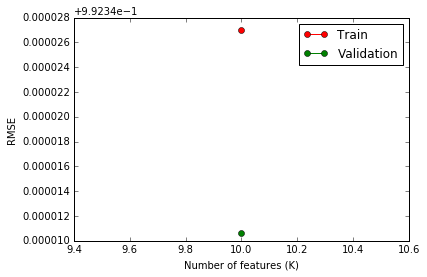

In [13]:
## !!! Takes long time to run

method = 2     # 0-SGD 1-ALS
K = 10         ## K-fold cross validation
gamma = 0.01
num_features_arr = [10]   # K in the lecture notes
lambda_user = 0.1
lambda_item = 0.7
min_num_ratings=10

train_rmse_mean = np.zeros(len(num_features_arr))
train_rmse_std = np.zeros(len(num_features_arr))
validation_rmse_mean = np.zeros(len(num_features_arr))
validation_rmse_std = np.zeros(len(num_features_arr))

for i, num_features in enumerate(num_features_arr):
    train_rmse_arr = []
    validation_rmse_arr = []
    
    print('Running num_features={n}'.format(n=num_features))
    [train_rmse_arr, validation_rmse_arr] = cross_validation(ratings, K, method, num_items_per_user, 
                                                             num_users_per_item, min_num_ratings, num_features, lambda_user, lambda_item)
        
    ## Calculate mean and standard deviation    
    train_rmse_mean[i] = np.mean(train_rmse_arr)
    train_rmse_std[i] = np.std(train_rmse_arr)
    validation_rmse_mean[i] = np.mean(validation_rmse_arr)
    validation_rmse_std[i] = np.std(validation_rmse_std)
    
## Plotting results
plt.fill_between(num_features_arr, train_rmse_mean - train_rmse_std,
                     train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
plt.fill_between(num_features_arr, validation_rmse_mean - validation_rmse_std,
                     validation_rmse_mean + validation_rmse_std, alpha=0.1, color="g")
plt.plot(num_features_arr, train_rmse_mean, 'o-', color="r")
plt.plot(num_features_arr, validation_rmse_mean, 'o-', color="g")
plt.legend(('Train', 'Validation'))
plt.xlabel('Number of features (K)'); plt.ylabel('RMSE');
plt.show()

In [14]:
print(train_rmse_mean)
print(train_rmse_std)
print(validation_rmse_mean)
print(validation_rmse_std)

[ 0.99236697]
[  1.11022302e-16]
[ 0.99235064]
[ 0.]


### lambda_user

In [ ]:
## !!! Takes long time to run

method = 0     # 0-SGD 1-ALS
K = 10        ## K-fold cross validation
gamma = 0.01
num_features = 20   # K in the lecture notes
lambda_user_arr = [0.01, 0.1, 1, 10]
lambda_item = 0.7

train_rmse_mean = np.zeros(len(lambda_user_arr))
train_rmse_std = np.zeros(len(lambda_user_arr))
validation_rmse_mean = np.zeros(len(lambda_user_arr))
validation_rmse_std = np.zeros(len(lambda_user_arr))

for i, lambda_user in enumerate(lambda_user_arr):
    train_rmse_arr = []
    validation_rmse_arr = []
    
    print('Running lambda_user={n}'.format(n=lambda_user))
    [train_rmse_arr, validation_rmse_arr] = cross_validation(ratings, K, method, num_items_per_user, 
                                                             num_users_per_item, min_num_ratings=10)
        
    train_rmse_mean[i] = np.mean(train_rmse_arr)
    train_rmse_std[i] = np.std(train_rmse_arr)
    validation_rmse_mean[i] = np.mean(validation_rmse_arr)
    validation_rmse_std[i] = np.std(validation_rmse_std)
    
## Plotting results
plt.fill_between(lambda_user_arr, train_rmse_mean - train_rmse_std,
                     train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
plt.fill_between(lambda_user_arr, validation_rmse_mean - validation_rmse_std,
                     validation_rmse_mean + validation_rmse_std, alpha=0.1, color="g")
plt.plot(lambda_user_arr, train_rmse_mean, 'o-', color="r")
plt.plot(lambda_user_arr, validation_rmse_mean, 'o-', color="g")
plt.legend(('Train', 'Validation'))
plt.xlabel('Lambda user'); plt.ylabel('RMSE');
plt.show()

### Lambda item

In [ ]:
## !!! Takes long time to run

method = 0     # 0-SGD 1-ALS
K = 10        ## K-fold cross validation
gamma = 0.01
num_features = 20   # K in the lecture notes
lambda_user = 0.1
lambda_item_arr = [0.01, 0.1, 0.5, 1]

train_rmse_mean = np.zeros(len(lambda_item_arr))
train_rmse_std = np.zeros(len(lambda_item_arr))
validation_rmse_mean = np.zeros(len(lambda_item_arr))
validation_rmse_std = np.zeros(len(lambda_item_arr))

for i, lambda_item in enumerate(lambda_item_arr):
    train_rmse_arr = []
    validation_rmse_arr = []
    
    print('Running lambda_item={n}'.format(n=lambda_item))
    [train_rmse_arr, validation_rmse_arr] = cross_validation(ratings, K, method, num_items_per_user, 
                                                             num_users_per_item, min_num_ratings=10)
        
    train_rmse_mean[i] = np.mean(train_rmse_arr)
    train_rmse_std[i] = np.std(train_rmse_arr)
    validation_rmse_mean[i] = np.mean(validation_rmse_arr)
    validation_rmse_std[i] = np.std(validation_rmse_std)
    
## Plotting results
plt.fill_between(lambda_item_arr, train_rmse_mean - train_rmse_std,
                     train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
plt.fill_between(lambda_item_arr, validation_rmse_mean - validation_rmse_std,
                     validation_rmse_mean + validation_rmse_std, alpha=0.1, color="g")
plt.plot(lambda_item_arr, train_rmse_mean, 'o-', color="r")
plt.plot(lambda_item_arr, validation_rmse_mean, 'o-', color="g")
plt.legend(('Train', 'Validation'))
plt.xlabel('Lambda item'); plt.ylabel('RMSE');
plt.show()

### Learning rate

In [ ]:
## !!! Takes long time to run

method = 0     # 0-SGD
K = 10        ## K-fold cross validation
gamma_arr = [0.01, 0.1, 1]
num_features = 20   # K in the lecture notes
lambda_user = 0.1
lambda_item = 0.5

train_rmse_mean = np.zeros(len(gamma_arr))
train_rmse_std = np.zeros(len(gamma_arr))
validation_rmse_mean = np.zeros(len(gamma_arr))
validation_rmse_std = np.zeros(len(gamma_arr))

for i, gamma in enumerate(gamma_arr):
    train_rmse_arr = []
    validation_rmse_arr = []
    
    print('Running gamma={n}'.format(n=gamma))
    [train_rmse_arr, validation_rmse_arr] = cross_validation(ratings, K, method, num_items_per_user, 
                                                             num_users_per_item, min_num_ratings=10)
        
    train_rmse_mean[i] = np.mean(train_rmse_arr)
    train_rmse_std[i] = np.std(train_rmse_arr)
    validation_rmse_mean[i] = np.mean(validation_rmse_arr)
    validation_rmse_std[i] = np.std(validation_rmse_std)
    
## Plotting results
plt.fill_between(gamma_arr, train_rmse_mean - train_rmse_std,
                     train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
plt.fill_between(gamma_arr, validation_rmse_mean - validation_rmse_std,
                     validation_rmse_mean + validation_rmse_std, alpha=0.1, color="g")
plt.plot(gamma_arr, train_rmse_mean, 'o-', color="r")
plt.plot(gamma_arr, validation_rmse_mean, 'o-', color="g")
plt.legend(('Train', 'Validation'))
plt.xlabel('Learning Rate'); plt.ylabel('RMSE');
plt.show()

### TODO
#### 1. Compare SGD, ALS with the best set of parameters (based on above results)